## Summary

The solution is based on a genetic algorithm where on each generation we select the individuals (group of triangles) that better reconstruct the target image. The hyper parameters of the solution are the number of triangles, the generations, the population size and the mutation rate. Also, we define the base color (background color) to help our solution reach a better reconstruction.

The code is implemented using 3 main classes: Gene, Individual, Population.  

1) The __Gene__ class defines a triangle.    
2) The __Individual__ class contains an group of genes and is able to build an image and calculate the fitness. It is also capable of doing crossover and mutation.  
3) The __Population__ class contains a group of individuals and is capable of performing selection of the fittest individuals and generation evolution.  

Using a typical colored small JPEG image (250*250 pixels) and with default hyper parameters (100 genes, 30 individuals, 4000 generations) the code runs in less than 5 minutes.

## The genetic algorithm

The genetic algorithm chosen is of the typical form:

1) Initial random population    
2) Fitness evaluation  
3) Selection of best individuals inside population  
4) Crossover between selected individuals  
5) Random gene mutation  
6) Back to step 2 until convergence or until end of generations  

Our choices for the imporant steps:

- __Fitness:__ Chose the pixelwise MSE   
- __Selection:__ Each generation selects the best 4 individuals based on fitness (pool)    
- __Crossover:__ For each chile we randomly choose 2 parents from the pool and do crossover with 3 random slice indexes  
- __Mutation:__ A mutation is equal to a random gene  

## Architecture

As explained before we base our architecture on 3 classes: Gene, Individual, Population. The Population class creates and handles sets of individuals and the Individual class creates and handles sets of genes. By making it this way our main function becomes extremely simple and concise, consisting only from a initialize population step and from iterations over the ".evolve()" method of the same Population instance. Using one population object only we have access to every individual and to every gene on any given time, with their respective methods.  

Further information about the classes and the methods can be found as comments at the beggining of each class.

## Future improvements

Future improvements are needed to increase the accuracy of the reconstruction, and other methods besides genetic algorithms should be considered. In general, a different fitness function that better represents the morphological and texture differences between the target image and the reconstructed image would be prudent. The pixel-wise MSE is certainly limited in many many senses.  

Also, another big consideration should be the number of genes (triangles) used on every generation. It is my opinion that using all 100 triangles from the very start may be problematic and may "hide" the individuals with very good basic shapes/colors that serve as structural background for the image, specially when having only 30 individuals compared to 100 genes. Following the same angle, we could also change and reduce the average size of the triangles as we advance on the generations, moving from gross tuning to fine tuning.  

## Import stuff

In [0]:
import numpy as np
import random
from numpy.random import choice
from PIL import Image, ImageDraw
from skimage import img_as_float
from skimage.measure import compare_mse as mse
from IPython.display import display

## Define the class "Gene"

In [0]:
# The class gene represents a triangle

# It has 7 attributes:
# - coord_1: One of the triangle vertices
# - coord_2: One of the triangle vertices
# - coord_3: One of the triangle vertices
# - colorR: The Red color component
# - colorG: The Green color component
# - colorB: The Blue color component
# - transparency: The transparency value of the colors channel

class gene():
    def __init__(self):
        self.coord_1 = random.randint(0, image_width), random.randint(0, image_height)
        self.coord_2 = random.randint(0, image_width), random.randint(0, image_height)
        self.coord_3 = random.randint(0, image_width), random.randint(0, image_height)
        self.colorR = random.randint(0, 255)
        self.colorG = random.randint(0, 255)
        self.colorB = random.randint(0, 255)
        self.transparency = 30

## Define the class "Individual"

In [0]:
# The class individual represents a collection of triangles
# It can be used to initialize a new individual or to generate a new individual
# given 2 parent individuals

# It has 3 attributes:
# - genes: A collection of genes (triangles)
# - image: The resulting image when drawing the triangles
# - fitness: The fitness value of the resulting image compared to target

# It has 4 methods:
# - cross: Perform crossover for when initializing from 2 parents
# - mutate: Perform random mutation of some genes
# - build_image: Builds the image using the triangles
# - calculate_fitness: Calculates the fitness against target image

class individual():
  
    def __init__(self, parent1=None, parent2=None):
        
        # We build a new individual either by random genes or by crossover
        # and mutation from 2 parents. Then we build the image and calculate 
        # the fitness
        
        self.genes = []
        if (parent1==None and parent2==None):      
          for i in range(NUM_TRIANGLES): 
            self.genes.append(gene())
        else:                                 
            self.cross(parent1, parent2)          
            self.mutate()                        
        self.image = self.build_image()          
        self.fitness = self.calculate_fitness()   

        
    def cross(self, parent1, parent2):
      
        # Cross over is performed by randomly selecting 3 slicing points and
        # then merging the slices from the 2 parents. Who goes first is decided
        # randomly with 50% chance
        
        if np.random.uniform(0, 1) > 0.5:
          parent1, parent2 = parent2, parent1
        
        cut_index1 = random.randint(0, NUM_TRIANGLES)
        cut_index2 = random.randint(0, NUM_TRIANGLES)
        cut_index3 = random.randint(0, NUM_TRIANGLES)
        
        self.genes[:cut_index1] = parent1.genes[:cut_index1]
        self.genes[cut_index1:cut_index2] = parent2.genes[cut_index1:cut_index2]
        self.genes[cut_index2:cut_index3] = parent1.genes[cut_index2:cut_index3]
        self.genes[cut_index3:] = parent2.genes[cut_index3:]
        

    def mutate(self):
      
        # A gene can mutate (is changed by a new and random gene) with given probability
        
        mutate_indices = np.where(np.random.uniform(0, 1, NUM_TRIANGLES) < MUTATION_RATE)
        for index in mutate_indices[0]:
          self.genes[index] = gene()

    def build_image(self):
      
        # Image is constructed by drawing the triangles. Background color is 
        # defined to help the algorithm converge. Otherwise the algorithm may
        # focus on finding the background color and not the details of the image
        
        image = Image.new('RGB', (image_width, image_height), BASE_COLOR)
        draw = ImageDraw.Draw(image, 'RGBA')
        for gene in self.genes:
          draw.polygon([gene.coord_1, gene.coord_2, gene.coord_3], 
                       fill=(gene.colorR, gene.colorG, gene.colorB, gene.transparency))
        return image

    def calculate_fitness(self):
      
        # Calculate fitness by mean pixel squared error. The minus is used so 
        # that images with lower MSE have larger fitness values
        fitness = -mse(img_as_float(self.image), target_image)
        return fitness   


## Define the class "Population"

In [0]:
# The class population is mainly a set of individuals
# It is initialized with new individuals that have new genes

# It has 2 methods:
# - selection_pool: Checks the fitness of all the contained individuals and
#                   selects the 4 individuals with the highest fitness
# - evolve: Given the 4 pre-selected individuals it creates a new generation of
#           individuals. Each new individual is created by randomly choosing 2 
#           past individuals from the pool that are crossed and allow to mutate.

class population():
  
  def __init__(self):
    
    # Create fresh and new individuals
    
    self.pop = []
    for i in range(POPULATION_SIZE):
      self.pop.append(individual())
      
  def selection_pool(self):
    
    # Choose the best 4 individuals based on fitness
    
    sorted_individuals = sorted(self.pop, key=lambda x: x.fitness, reverse=True)
    pool = sorted_individuals[:4]
    return pool
    
  def evolve(self):
    
    # Random select 2 parents, cross them and mutate them to create new individuals
    
    pool = self.selection_pool()
    self.pop = []
    for i in range(POPULATION_SIZE):
      chosen = np.random.choice(pool, 2, replace=False)
      self.pop.append(individual(chosen[0], chosen[1]))  
    


## Load target image

In [170]:
from google.colab import files
from io import BytesIO

# Image must be called "image.jpg"
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['image.jpg']))
target_image = img_as_float(np.asarray(im))

Saving image.jpg to image (3).jpg


## Run

Running generation number: 0
Running generation number: 500
Running generation number: 1000
Running generation number: 1500
Running generation number: 2000
Running generation number: 2500
Running generation number: 3000
Running generation number: 3500


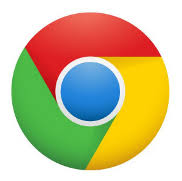

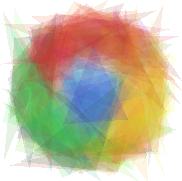

In [174]:
POPULATION_SIZE = 30
NUM_TRIANGLES = 100
MUTATION_RATE = 0.02
BASE_COLOR = 'white'
GENERATIONS = 4000

if __name__ == "__main__":
  
  # Get the target image size
  image_height = target_image.shape[0]
  image_width = target_image.shape[1]
  
  # Initialize
  popu = population()
  
  # Run for the number of generations
  for i in range(GENERATIONS):
    if i%500==0:
      print("Running generation number: " + str(i))
    popu.evolve()
  
  # Display target image and best reconstruction
  sorted_ind = sorted(popu.pop, key=lambda x: x.fitness, reverse=True)
  display(im)
  display(sorted_ind[0].image)